In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from pprint import pprint

In [2]:
df = pd.read_csv('updated_diamonds.csv')

## EDA 

In [3]:
df.drop('Unnamed: 0',axis =1, inplace=True) #removing column that was basically the same as the index
df.drop_duplicates(inplace = True) #might be some duplicate rows based on the way the data was scraped (changing floor price)

In [4]:
df.shape

(52461, 14)

In [5]:
df.info() #data types are as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52461 entries, 0 to 52885
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shape             52461 non-null  object 
 1   original_price    52461 non-null  int64  
 2   discounted_price  6796 non-null   float64
 3   carat             52461 non-null  float64
 4   cut               52461 non-null  object 
 5   color             52461 non-null  object 
 6   clarity           52461 non-null  object 
 7   polish            52461 non-null  object 
 8   symmetry          52461 non-null  object 
 9   fluorescence      52461 non-null  object 
 10  depth             52461 non-null  float64
 11  table             52461 non-null  float64
 12  lxwratio          52461 non-null  float64
 13  culet             52461 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 6.0+ MB


Need to remove discounted price since we are trying to predict original price or else there might be data leakage - model will have the information you are trying to predict

In [6]:
df.drop('discounted_price',axis =1,inplace = True)

In [7]:
#Astor Ideal and showing up as ealAstor - need to update
df['cut'] = df['cut'].replace('ealAstor','Astor Ideal')

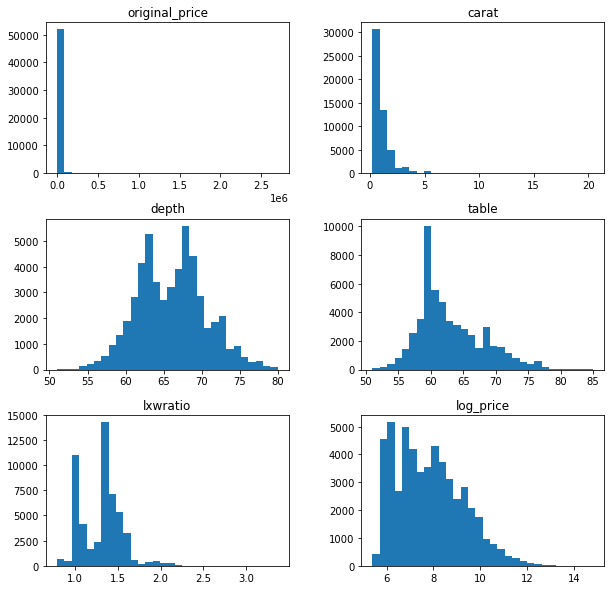

In [8]:
df['log_price'] = np.log(df['original_price'])
df.hist(figsize=(10,10),bins=30,grid=False);

Distribution of price is right skewed - take the log to see the distribution better

Text(0, 0.5, 'Frequency')

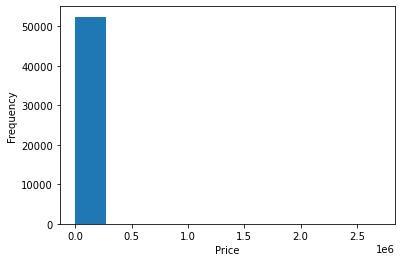

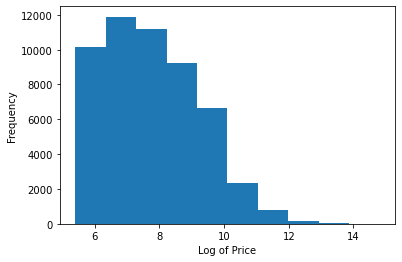

In [9]:
fig, ax = plt.subplots()
ax.hist(df['original_price'])
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')

fig, ax = plt.subplots()
ax.hist(df['log_price'])
ax.set_xlabel('Log of Price')
ax.set_ylabel('Frequency')

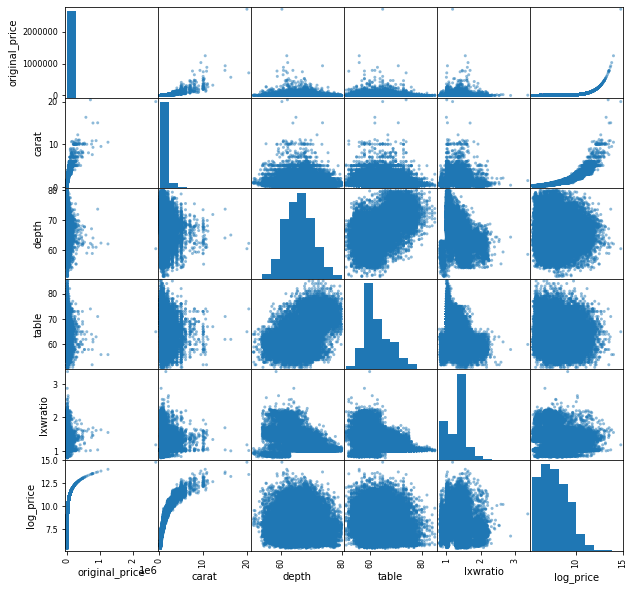

In [10]:
pd.plotting.scatter_matrix(df,figsize=(10,10));

In [11]:
df.describe()

,original_price,carat,depth,table,lxwratio,log_price
count,5.246100e+04,52461.000000,52461.000000,52461.000000,52461.000000,52461.000000
mean,7.941095e+03,0.993874,66.088462,62.946719,1.308527,7.806021
std,2.688281e+04,0.909858,4.517800,5.039816,0.236147,1.411813
min,2.210000e+02,0.230000,51.000000,51.000000,0.790000,5.398163
25%,7.930000e+02,0.400000,62.700000,59.000000,1.050000,6.675823
50%,2.152000e+03,0.710000,66.200000,62.000000,1.350000,7.674153
75%,6.409000e+03,1.200000,68.900000,66.000000,1.440000,8.765459
max,2.702260e+06,20.450000,80.000000,85.000000,3.370000,14.809599


There are outliers - one diamond is almost 3 million dollars! 

In [12]:
df.corr()

,original_price,carat,depth,table,lxwratio,log_price
original_price,1.000000,0.750451,-0.001705,0.009492,-0.022267,0.510031
carat,0.750451,1.000000,0.050836,0.015941,-0.111207,0.867236
depth,-0.001705,0.050836,1.000000,0.592803,-0.555673,0.030710
table,0.009492,0.015941,0.592803,1.000000,-0.446653,-0.035061
lxwratio,-0.022267,-0.111207,-0.555673,-0.446653,1.000000,-0.124706
log_price,0.510031,0.867236,0.030710,-0.035061,-0.124706,1.000000


Have a lot of categorical variables - let's change to ordinal encoding so we can see if there are any correlations inclusive of the categorical features

In [13]:
#ascending order
cut_ord = ['Good', 'Very Good', 'Astor Ideal']
clarity_ord = ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']
color_ord = ['K', 'J', 'I', 'H', 'G', 'F', 'E', 'D']
polish_ord = ['Good','Very Good','Excellent']
symmetry_ord = ['Good','Very Good','Excellent']

def cat_mapper(categories):
    i = 0
    mapped = {}
    for cat in categories:
        mapped[cat] = i
        i+=1
    return mapped

In [14]:
cut_ord = cat_mapper(cut_ord)
clarity_ord = cat_mapper(clarity_ord)
color_ord = cat_mapper(color_ord)
polish_ord = cat_mapper(polish_ord)
symmetry_ord = cat_mapper(symmetry_ord)

In [15]:
df_ord = df.copy()
df_ord['cut'].replace(cut_ord,inplace=True)
df_ord['clarity'].replace(clarity_ord,inplace=True)
df_ord['color'].replace(color_ord,inplace=True)
df_ord['polish'].replace(polish_ord,inplace=True)
df_ord['symmetry'].replace(symmetry_ord,inplace=True)
df_ord

,shape,original_price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,lxwratio,culet,log_price
0,Emerald,221,0.30,0,1,2,1,0,None,70.0,61.0,1.33,None,5.398163
1,Emerald,224,0.30,1,1,1,2,1,Faint,65.9,66.0,1.42,None,5.411646
2,Emerald,224,0.30,1,1,1,2,1,Faint,66.6,66.0,1.28,None,5.411646
3,Pear,225,0.30,1,1,1,1,1,Faint,61.7,62.0,1.60,None,5.416100
4,Pear,226,0.30,1,1,0,1,1,None,62.5,59.0,1.57,None,5.420535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52881,Pear,882083,10.88,1,7,7,2,2,Faint,60.9,63.0,1.61,None,13.690041
52882,Princess,930395,15.06,1,5,3,2,2,None,73.7,71.0,1.03,None,13.743365
52883,Pear,1030445,9.52,1,7,7,2,1,None,62.3,56.0,1.63,None,13.845501
52884,Pear,1244433,10.51,1,7,7,2,2,None,62.0,56.0,1.55,None,14.034191


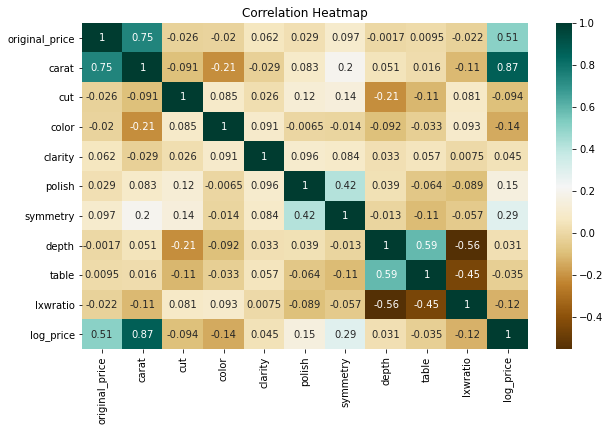

In [16]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_ord.corr(),cmap = 'BrBG',annot = True)
heatmap.set_title('Correlation Heatmap');

Since there are outliers - we might want to only include diamonds that are <= $500,000 and <= 9.5 carats - TBD 

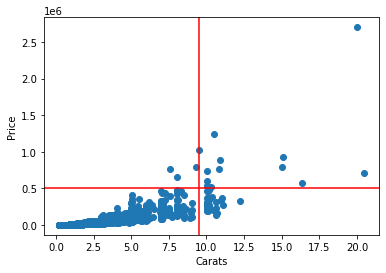

In [17]:
fig,ax = plt.subplots()
ax.scatter(df.carat,(df.original_price))
ax.set_xlabel('Carats')
ax.set_ylabel('Price')
plt.axvline(x=9.5, color = 'r')
plt.axhline(500000, color = 'r');

Plot to see if there are any specific patterns that jump out with respect to price. Only looking at those that are <= $500,000 and <= 9.5 carats

In [18]:
df_filtered = df[(df.carat<=9.5) & (df.original_price<=500000)]
print(f'Percent of data to drop: {df[(df.carat>9.5) & (df.original_price>600000)].shape[0]/df.shape[0]*100}%')

Percent of data to drop: 0.017155601303825697%


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


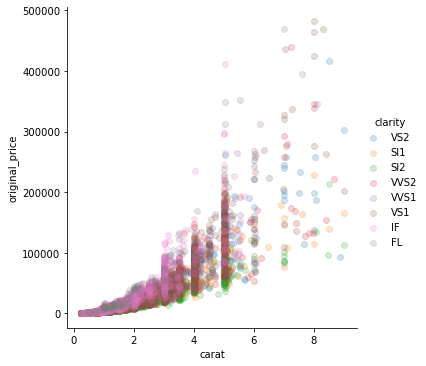

In [19]:
sns.lmplot('carat','original_price', data=df_filtered,hue='clarity', fit_reg =False, scatter_kws = {'alpha': 0.2});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


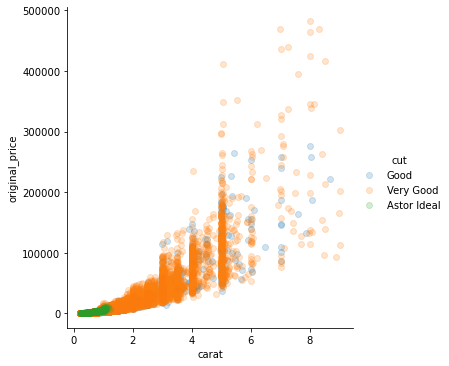

In [20]:
sns.lmplot('carat','original_price', data=df_filtered,hue='cut', fit_reg =False, scatter_kws = {'alpha': 0.2});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


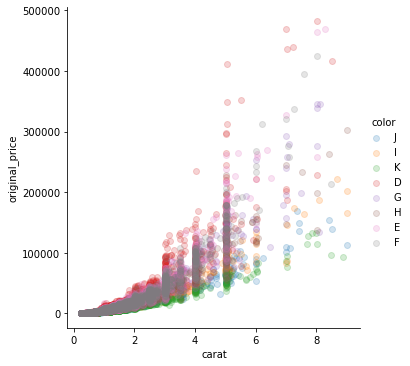

In [21]:
sns.lmplot('carat','original_price', data=df_filtered,hue='color', fit_reg =False, scatter_kws = {'alpha': 0.2});

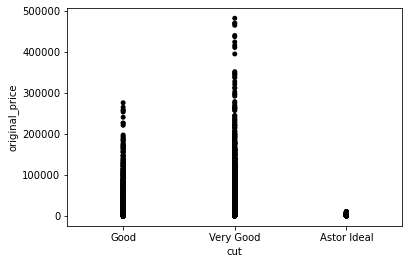

In [22]:
sns.stripplot(data = df_filtered,
              x='cut', y='original_price', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

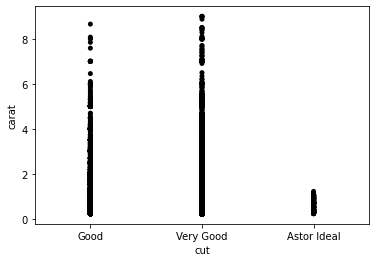

In [23]:
sns.stripplot(data = df_filtered,
              x='cut', y='carat', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

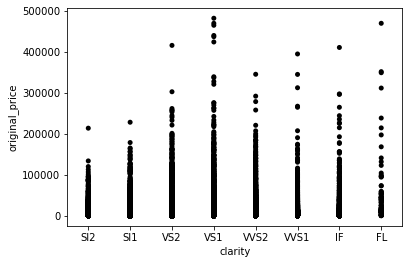

In [24]:
sns.stripplot(data = df_filtered,
              x='clarity', y='original_price', 
              order = ['SI2','SI1','VS2','VS1','VVS2','VVS1','IF','FL'],
              color = 'black', jitter=False);

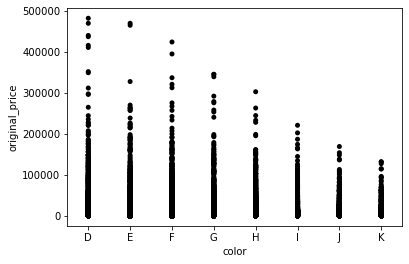

In [25]:
sns.stripplot(data = df_filtered,
              x='color', y='original_price', 
              order = ['D', 'E','F','G','H','I','J','K'],
              color = 'black', jitter=False);

## ML Models

Given that price has a huge range (~200 - ~3 million) and right skewed - taking the log should help. If not, consider filtering the diamonds that we're considering

In [26]:
def default_models(X,y, model=LinearRegression):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 23)
    
    default_model = model().fit(X_train,y_train)
    y_predicted = default_model.predict(X_test)
    
    train_rmse = (f'Train RMSE: {(-cross_val_score(default_model,X_train,y_train,scoring="neg_root_mean_squared_error")).mean()}')
    test_rmse = (f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted))}')
    train_r2 = (f'Train R2: {cross_val_score(default_model,X_train,y_train,scoring="r2").mean()}')
    test_r2 = (f'Test R2: {r2_score(y_test,y_predicted)}')
    mape = (f'Mean Absolute Percentage Error: {np.exp(mean_absolute_percentage_error(y_test,y_predicted))}')
    
    
    residuals = y_predicted - y_test

    fig,ax = plt.subplots()
    ax.scatter(y_predicted,residuals)
    plt.axhline(y=0, color = 'r')
    ax.set_xlabel('Predicted Prices')
    ax.set_ylabel('Residuals');
    
    return train_rmse, test_rmse, train_r2, test_r2, mape

#### Given that carats are so highly correlated with price - let's try just predicting on carat as a baseline model.

Lin Reg - Residual plot does not look good. Looks heteroskedastic - surprisingly taking the log did not help in this case.
Additionally, given the shape of the residual plot - it seems like we will need to rethink/tweak this model 

('Train RMSE: 0.7035826837162368',
 'Test RMSE: 0.7011388264408682',
 'Train R2: 0.7498413147203608',
 'Test R2: 0.7576880710421483',
 'Mean Absolute Percentage Error: 1.0731003545308115')

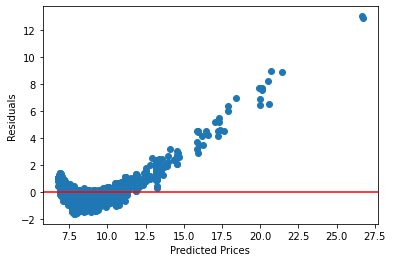

In [27]:
#linear regression
X = pd.DataFrame(df.carat)
y = df.log_price
default_models(X,y)

Try the same thing with Random Forest

Residual plot looks good. Did taking the log help or will predicting on original price be similar? Let's try predicting original price to compare

('Train RMSE: 0.279608300923408',
 'Test RMSE: 0.27846065855660146',
 'Train R2: 0.9605482474832161',
 'Test R2: 0.9617796682898374',
 'Mean Absolute Percentage Error: 1.0289586388647642')

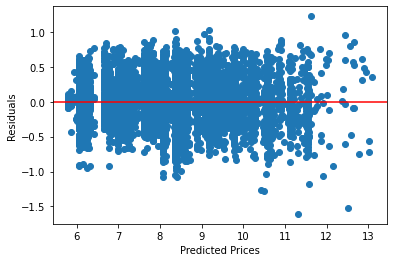

In [28]:
#random forest
default_models(X,y, model=RandomForestRegressor)

While predicting the log of the price is harder to interpret and will need to be changed back to original units - it definitely helped with the heteroskedasticity unlike the below plot.

('Train RMSE: 15703.733194746095',
 'Test RMSE: 14138.191858711098',
 'Train R2: 0.6126374140122034',
 'Test R2: 0.7159650241382187',
 'Mean Absolute Percentage Error: 1.270550356243713')

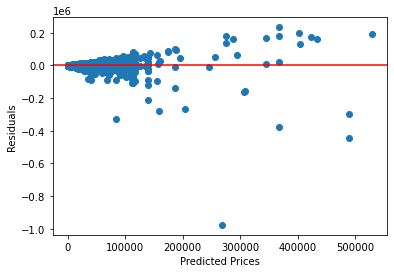

In [29]:
#random forest - predicting original price
X = pd.DataFrame(df.carat)
y = df.original_price
default_models(X,y,model=RandomForestRegressor)

Update function to account for predicting log price - convert back to original price units for easier interpretability before moving forward with improving the model.

In [167]:
def updated_default_models(X,y, model=LinearRegression, log = False, gini = False, percent_error = False ):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 23)
    
    if log == False:
        default_model = model().fit(X_train,y_train)
        y_predicted = default_model.predict(X_test)
        train_rmse = (f'Train RMSE: {(-cross_val_score(default_model,X_train,y_train,scoring="neg_root_mean_squared_error")).mean()}')
        test_rmse = (f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted))}')
        train_r2 = (f'Train R2: {cross_val_score(default_model,X_train,y_train,scoring="r2").mean()}')
        test_r2 = (f'Test R2: {r2_score(y_test,y_predicted)}')
        mape = (f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted)}')
        residuals = y_predicted - y_test
    else:
        fold_rmse = []
        fold_r2 = []
        # need to manually do KFolds to get rid of log during cross val
        # use default folds - which is 5 same as default for cross val score
        # reminder - KFold object returns indices not the data 
        kf = KFold(shuffle=True, random_state = 23)
        for train, test in kf.split(X_train):
            default_model = model().fit(X_train.values[train],y_train.values[train])
            predicted_log = default_model.predict(X_train.values[test])
            predicted_non_log = np.exp(predicted_log)
            true_non_log = np.exp(y_train.values[test])
            #want to take the log out for rmse to easier interpretability 
            fold_rmse.append(np.sqrt(np.mean((predicted_non_log-true_non_log)**2)))
            fold_r2.append(r2_score(y_train.values[test],predicted_log))
        train_rmse = np.mean(fold_rmse)
        train_r2 = np.mean(fold_r2)
        
        
        default_model = model().fit(X_train,y_train)
        y_predicted = default_model.predict(X_test)
        y_predicted_non_log = np.exp(y_predicted)
        
        test_rmse = np.sqrt(np.mean((y_predicted_non_log-np.exp(y_test))**2))
        test_r2 = r2_score(y_test,y_predicted)
        
        mape = (f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(np.exp(y_test),y_predicted_non_log)}')
        
        # want the residuals of when it was log - not after conversion 
        #residuals = y_predicted - np.exp(y_test)
        residuals = y_predicted - y_test


    fig,ax = plt.subplots()
    ax.scatter(y_predicted,residuals)
    plt.axhline(y=0, color = 'r')
    ax.set_xlabel('Predicted Prices')
    ax.set_ylabel('Residuals')
    
    
    # Plot the gini importance
    
    if gini == True:
        fig, ax = plt.subplots()
        feat_scores = pd.Series(default_model.feature_importances_,
                                   index=X_train.columns)
        feat_scores = feat_scores.sort_values()
        ax = feat_scores.plot(kind='barh', 
                              figsize=(10,20),
                              color='b')
        ax.set_title('Average Gini Importance')
        ax.set_xlabel('Average contribution to information gain')
        
    if percent_error == True:
        percent_error = np.abs(y_predicted-y_test)/y_test*100
        fig,ax = plt.subplots()
        ax.scatter(y_test,percent_error)
        plt.axhline(y=0, color = 'r')
        ax.set_ylabel('Percent error')
        if log == False:
            ax.set_xlabel('Original Price')
        else: 
            ax.set_xlabel('Log Price')
        
    
    return train_rmse, test_rmse, train_r2, test_r2, mape

Double check that the updated function works as intended - looks good for both log and original price

(15179.380612235278,
 14095.334260351121,
 0.9604188336047079,
 0.9617556348272596,
 'Mean Absolute Percentage Error: 0.22865784462499883')

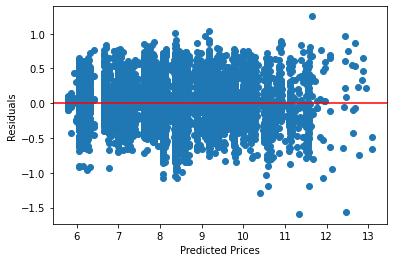

In [168]:
#random forest - predicting log price using updated function
X = pd.DataFrame(df.carat)
y = df.log_price
updated_default_models(X,y,model=RandomForestRegressor, log=True)
#train rmse vs rmse test below looks to be underfitting

('Train RMSE: 15343.654338493248',
 'Test RMSE: 14238.515804108441',
 'Train R2: 0.6053417785787178',
 'Test R2: 0.7119197245563094',
 'Mean Absolute Percentage Error: 0.23930739240122273')

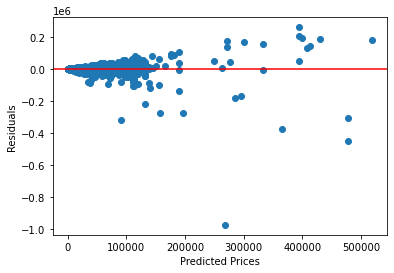

In [169]:
#random forest - predicting original price using updated function
X = pd.DataFrame(df.carat)
y = df.original_price
updated_default_models(X,y,model=RandomForestRegressor, log=False)

#### Try predicting with the 4Cs

Sticking to random forest - does better than linear regression and residual plots look good

(9803.2297550533,
 8975.676089613778,
 0.9900756130066876,
 0.9902308664465456,
 'Mean Absolute Percentage Error: 0.10784175412865794')

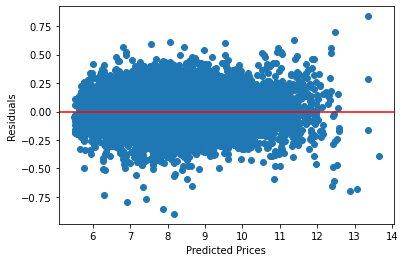

In [170]:
#random forest - 4Cs/log price
X = pd.get_dummies(df[['carat','cut','clarity','color']])
y = df.log_price
updated_default_models(X,y,model=RandomForestRegressor, log=True)
#train rmse vs rmse test below looks to be underfitting - try changing parameters later
# and also try all features to look at gini importance to tweak our model

Categorical variables are not purely categorical (i.e. symmetry: good, very good, excellent) - there is some sort of "ranking" between the values. Let's try the same thing as above with the 4Cs but try ordinal encoding instead!

In [171]:
#ascending order
cut_ord = ['Good', 'Very Good', 'Astor Ideal']
clarity_ord = ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']
color_ord = ['K', 'J', 'I', 'H', 'G', 'F', 'E', 'D']
polish_ord = ['Good','Very Good','Excellent']
symmetry_ord = ['Good','Very Good','Excellent']

def cat_mapper(categories):
    i = 0
    mapped = {}
    for cat in categories:
        mapped[cat] = i
        i+=1
    return mapped

In [172]:
cut_ord = cat_mapper(cut_ord)
clarity_ord = cat_mapper(clarity_ord)
color_ord = cat_mapper(color_ord)
polish_ord = cat_mapper(polish_ord)
symmetry_ord = cat_mapper(symmetry_ord)

df_ord = df.copy()
df_ord['cut'].replace(cut_ord,inplace=True)
df_ord['clarity'].replace(clarity_ord,inplace=True)
df_ord['color'].replace(color_ord,inplace=True)
df_ord['polish'].replace(polish_ord,inplace=True)
df_ord['symmetry'].replace(symmetry_ord,inplace=True)

In [173]:
# ordinal encoding looks good
df_ord.head()

,shape,original_price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,lxwratio,culet,log_price
0,Emerald,221,0.3,0,1,2,1,0,None,70.0,61.0,1.33,None,5.398163
1,Emerald,224,0.3,1,1,1,2,1,Faint,65.9,66.0,1.42,None,5.411646
2,Emerald,224,0.3,1,1,1,2,1,Faint,66.6,66.0,1.28,None,5.411646
3,Pear,225,0.3,1,1,1,1,1,Faint,61.7,62.0,1.60,None,5.416100
4,Pear,226,0.3,1,1,0,1,1,None,62.5,59.0,1.57,None,5.420535


(9979.546819685373,
 7576.682337086601,
 0.9901844779039823,
 0.9904220074176523,
 'Mean Absolute Percentage Error: 0.10727709152423284')

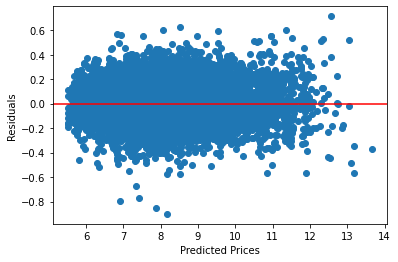

In [174]:
#random forest ordinal encoding - 4Cs/log price
X = pd.get_dummies(df_ord[['carat','cut','clarity','color']])
y = df_ord.log_price
updated_default_models(X,y,model=RandomForestRegressor, log=True)
#train rmse vs rmse test below looks to be underfitting - try changing parameters later
# and also try all features to look at gini importance to tweak our model

Doesn't look like theres a difference between ordinal encoding vs one hot encoding for categorical variables

Let's try using all features and looking at the gini importance to see how we might improve our model

Majority of diamonds are 500K and lower. So while and RMSE of 10K is not a lot for a 3 million dollar ring, it is a significant amount for the lower priced diamonds.

(10315.757217268942,
 9691.592861648394,
 0.9939935215578863,
 0.9941592724885512,
 'Mean Absolute Percentage Error: 0.07931726490588152')

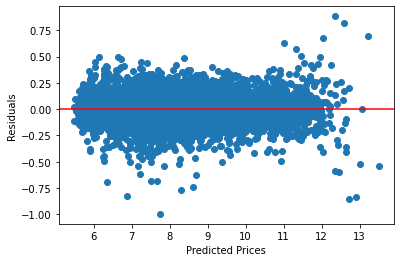

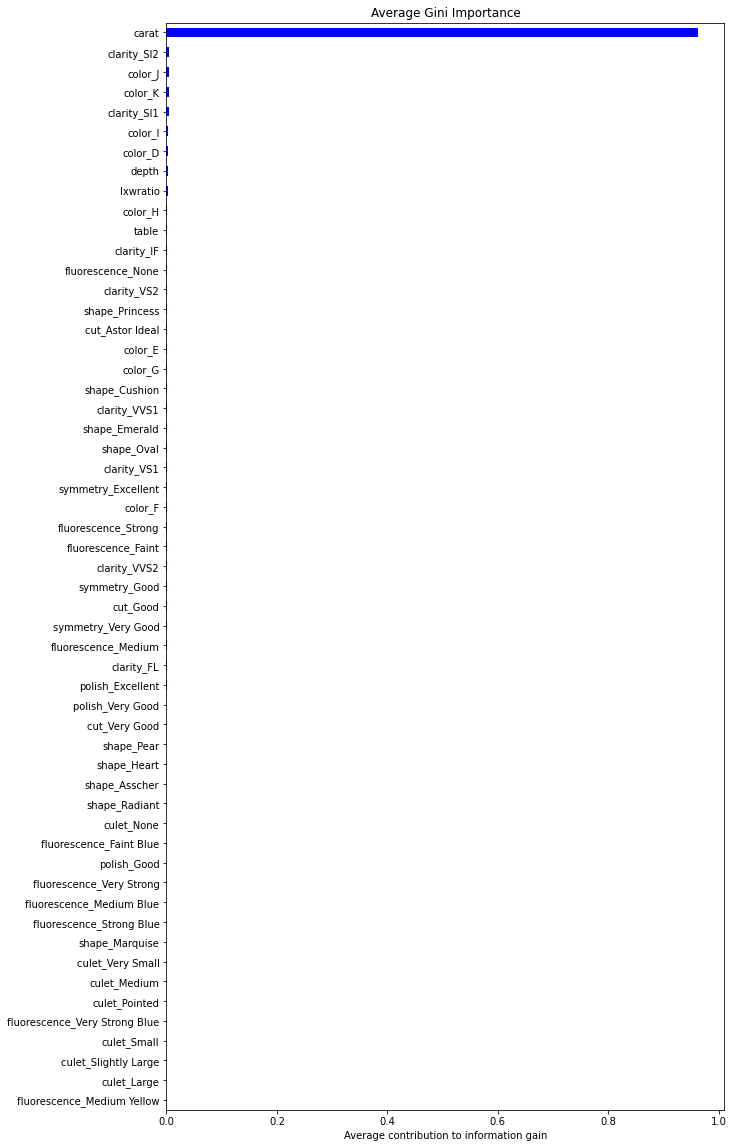

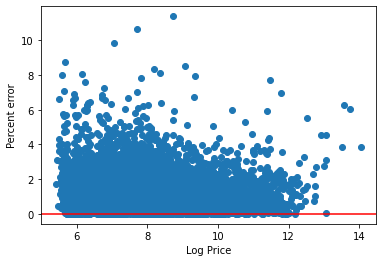

In [175]:
#random forest all features
X = pd.get_dummies(df.drop(['original_price','log_price'],axis=1))
y = df.log_price
updated_default_models(X,y,model=RandomForestRegressor, log=True, gini = True, percent_error = True)

While it is not surprising that carats is the highest on the gini importance, it is surprisingly that everything else is comparatively a lot lower. It does not seem like adding other features is improving the model that much more.

Try plotting some charts to see if there are any patterns where we are consistently over-estimating/ under-estimating

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 23)
rf = RandomForestRegressor().fit(X_train,y_train)
y_pred = rf.predict(X_test)
actual_predicted = pd.DataFrame(y_test)
actual_predicted['predicted'] = y_pred
actual_predicted['diff'] = actual_predicted.predicted - actual_predicted.log_price
actual_predicted = actual_predicted.merge(df.drop(['log_price'],axis=1), left_index=True,right_index=True,how='inner')

In [177]:
#under predicted
under = actual_predicted[actual_predicted['diff']<0]
#over predicted
over = actual_predicted[actual_predicted['diff']>0]

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


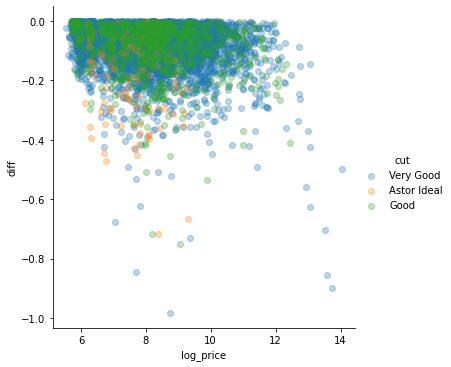

In [178]:
sns.lmplot('log_price','diff', data=under,hue='cut', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


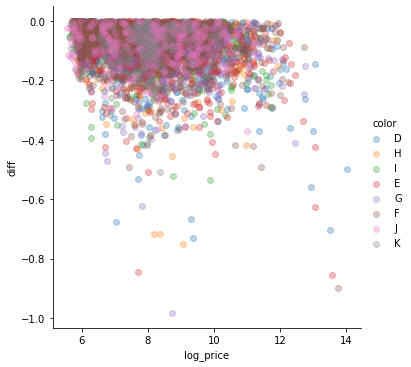

In [179]:
sns.lmplot('log_price','diff', data=under,hue='color', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


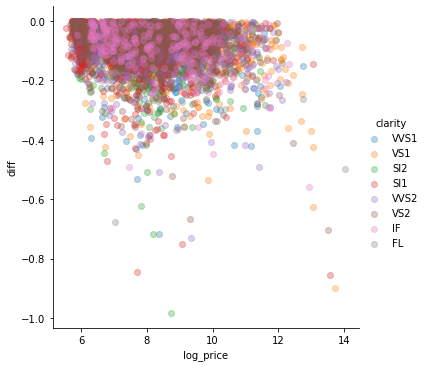

In [180]:
sns.lmplot('log_price','diff', data=under,hue='clarity', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


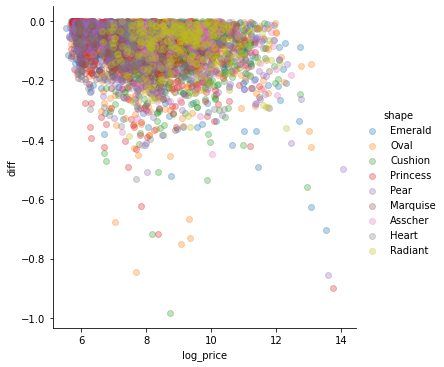

In [181]:
sns.lmplot('log_price','diff', data=under,hue='shape', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


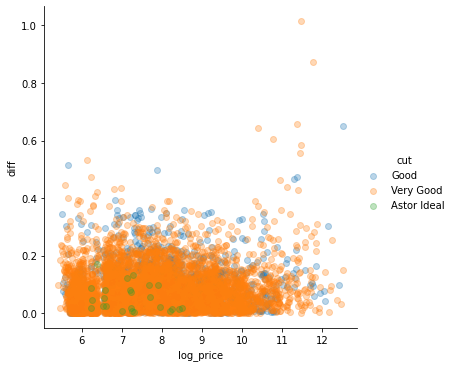

In [182]:
sns.lmplot('log_price','diff', data=over,hue='cut', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


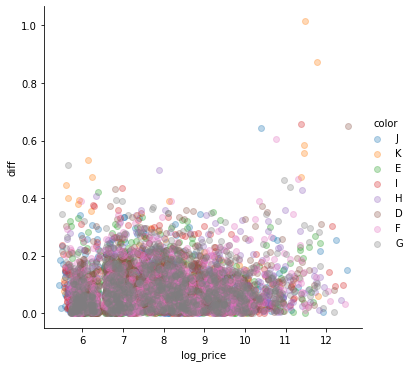

In [183]:
sns.lmplot('log_price','diff', data=over,hue='color', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


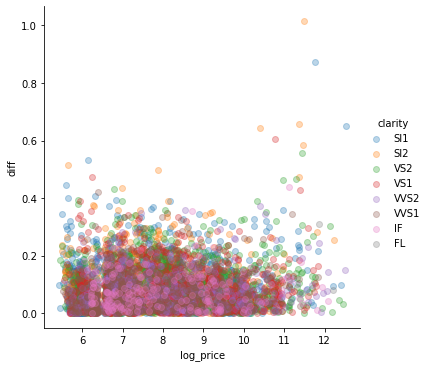

In [184]:
sns.lmplot('log_price','diff', data=over,hue='clarity', fit_reg =False,scatter_kws={'alpha': 0.3});

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


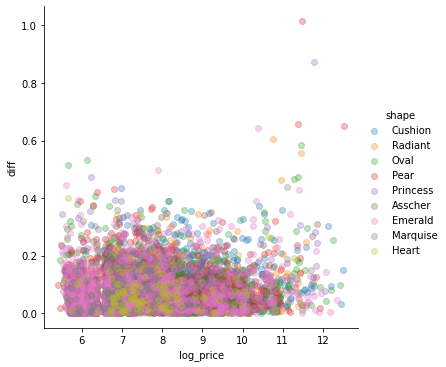

In [185]:
sns.lmplot('log_price','diff', data=over,hue='shape', fit_reg =False,scatter_kws={'alpha': 0.3});

Does not look like we are systematically under-estimating/over-estimating

Our model will probably do better by filtering out outliers - even if we are taking the log of the price to help with some of the higher ranged diamonds

(3884.2724168611726,
 4281.564585316653,
 0.9940693409842216,
 0.9941727106301537,
 'Mean Absolute Percentage Error: 0.07885528575849357')

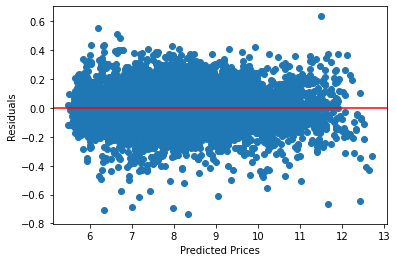

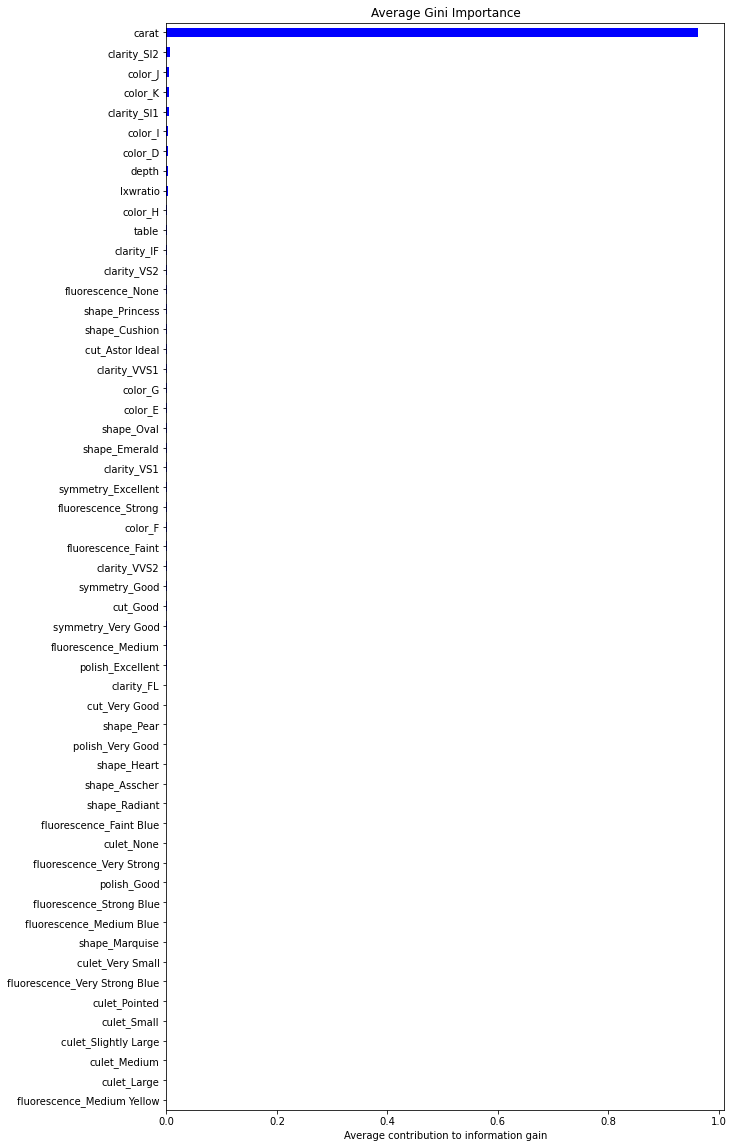

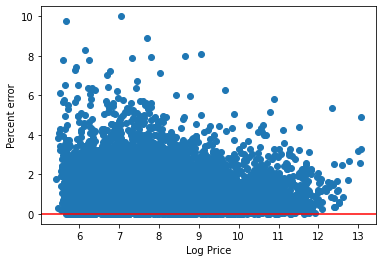

In [186]:
#random forest 4Cs log price - filtered <= 500K and <= 9.5 carats 
X = pd.get_dummies(df_filtered.drop(['original_price','log_price'],axis=1))
y = df_filtered.log_price
updated_default_models(X,y,model=RandomForestRegressor, log=True, gini = True, percent_error = True)
# underfitting with default parameters and current features

We do worse for the lower priced diamonds - and under and over estimate about half the time

In [193]:
print(f' % over-estimated {len(over)/len(actual_predicted)}')
print(f' % under-estimated {len(under)/len(actual_predicted)}')

 % over-estimated 0.5077005184507472
 % under-estimated 0.49229948154925285


Don't think we have enough information to truly predict diamond prices at the moment. Let's try gradient boosting first and then finalize on a model to hypertune.

(11249.431523514473,
 11199.500818021706,
 0.9898139879235753,
 0.9899078365992032,
 'Mean Absolute Percentage Error: 0.11093496507282224')

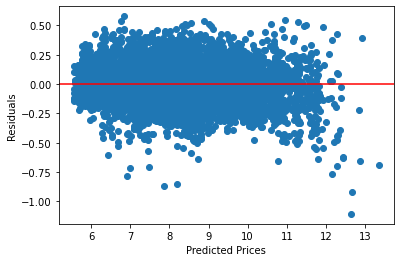

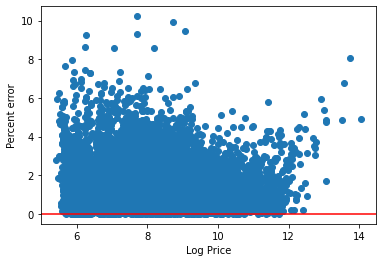

In [199]:
#gradient boosting regressor - 4Cs/log price
X = pd.get_dummies(df[['carat','cut','clarity','color']])
y = df.log_price
updated_default_models(X,y,model=GradientBoostingRegressor, log=True, percent_error = True)
#train rmse vs rmse test below looks to be underfitting - try changing parameters later
# and also try all features to look at gini importance to tweak our model

Surprisingly - Random Forest with its default parameters performed better than Gradient Boosting Regressor. Hypteruning should help GBR outperform Random Forest.

In [214]:
X = pd.get_dummies(df[['carat','cut','clarity','color']])
y = df.log_price
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 23)

model = GradientBoostingRegressor()

grid = {'max_depth': [2,4,8],
        'min_samples_split': [ 2, 4, 8]}

gb_gridsearch = GridSearchCV(estimator=model, param_grid=grid, 
                             cv=5, verbose=0, return_train_score=True)

gb_gridsearch.fit(X_train, y_train)

df_gridsearch = pd.DataFrame(gb_gridsearch.cv_results_)

In [215]:
df_gridsearch.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.003435,0.090334,0.010635,0.000903,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.986633,0.986636,0.986965,...,0.986629,0.000230,7,0.986859,0.986927,0.986918,0.986906,0.986946,0.986911,0.000029
1,0.907196,0.012858,0.010235,0.000542,2,4,"{'max_depth': 2, 'min_samples_split': 4}",0.986633,0.986636,0.986965,...,0.986629,0.000230,7,0.986859,0.986927,0.986918,0.986906,0.986946,0.986911,0.000029
2,0.967240,0.052480,0.011355,0.000904,2,8,"{'max_depth': 2, 'min_samples_split': 8}",0.986633,0.986636,0.986965,...,0.986629,0.000230,7,0.986859,0.986927,0.986918,0.986906,0.986946,0.986911,0.000029
3,1.870886,0.022329,0.017066,0.001087,4,2,"{'max_depth': 4, 'min_samples_split': 2}",0.990800,0.990887,0.990942,...,0.990811,0.000098,5,0.991121,0.991165,0.991223,0.991194,0.991241,0.991189,0.000043
4,1.754385,0.107996,0.015450,0.000601,4,4,"{'max_depth': 4, 'min_samples_split': 4}",0.990784,0.990882,0.990947,...,0.990809,0.000096,6,0.991116,0.991169,0.991234,0.991195,0.991240,0.991191,0.000046


In [216]:

max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()

max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

max_scores

mean_test_score                     mean_train_score  \
param_min_samples_split               2         4         8                2   
param_max_depth                                                                
2                              0.986629  0.986629  0.986629         0.986911   
4                              0.990811  0.990809  0.990812         0.991189   
8                              0.991231  0.991244  0.991243         0.992885   

                                             
param_min_samples_split         4         8  
param_max_depth                              
2                        0.986911  0.986911  
4                        0.991191  0.991186  
8                        0.992858  0.992809

In [227]:
def gbr(X,y,log = False, percent_error = False ):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 23)
    
    if log == False:
        gbr = GradientBoostingRegressor(min_samples_split=8, max_depth = 8).fit(X_train,y_train)
        y_predicted = gbr.predict(X_test)
        train_rmse = (f'Train RMSE: {(-cross_val_score(gbr,X_train,y_train,scoring="neg_root_mean_squared_error")).mean()}')
        test_rmse = (f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted))}')
        train_r2 = (f'Train R2: {cross_val_score(gbr,X_train,y_train,scoring="r2").mean()}')
        test_r2 = (f'Test R2: {r2_score(y_test,y_predicted)}')
        mape = (f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted)}')
        residuals = y_predicted - y_test
    else:
        fold_rmse = []
        fold_r2 = []
        # need to manually do KFolds to get rid of log during cross val
        # use default folds - which is 5 same as default for cross val score
        # reminder - KFold object returns indices not the data 
        kf = KFold(shuffle=True, random_state = 23)
        for train, test in kf.split(X_train):
            gbr = GradientBoostingRegressor(min_samples_split=8, max_depth = 8).fit(X_train.values[train],y_train.values[train])
            predicted_log = gbr.predict(X_train.values[test])
            predicted_non_log = np.exp(predicted_log)
            true_non_log = np.exp(y_train.values[test])
            #want to take the log out for rmse to easier interpretability 
            fold_rmse.append(np.sqrt(np.mean((predicted_non_log-true_non_log)**2)))
            fold_r2.append(r2_score(y_train.values[test],predicted_log))
        train_rmse = np.mean(fold_rmse)
        train_r2 = np.mean(fold_r2)
        
        
        gbr = GradientBoostingRegressor(min_samples_split=8, max_depth = 8).fit(X_train,y_train)
        y_predicted = gbr.predict(X_test)
        y_predicted_non_log = np.exp(y_predicted)
        
        test_rmse = np.sqrt(np.mean((y_predicted_non_log-np.exp(y_test))**2))
        test_r2 = r2_score(y_test,y_predicted)
        
        mape = (f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(np.exp(y_test),y_predicted_non_log)}')
        
        # want the residuals of when it was log - not after conversion 
        #residuals = y_predicted - np.exp(y_test)
        residuals = y_predicted - y_test


    fig,ax = plt.subplots()
    ax.scatter(y_predicted,residuals)
    plt.axhline(y=0, color = 'r')
    ax.set_xlabel('Predicted Prices')
    ax.set_ylabel('Residuals')
        
    
    return train_rmse, test_rmse, train_r2, test_r2, mape

(8628.044258795991,
 7547.8123106443745,
 0.9912173942776781,
 0.9913341719721637,
 'Mean Absolute Percentage Error: 0.10261715991342987')

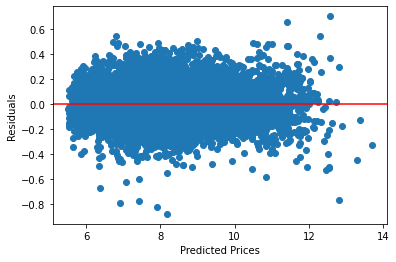

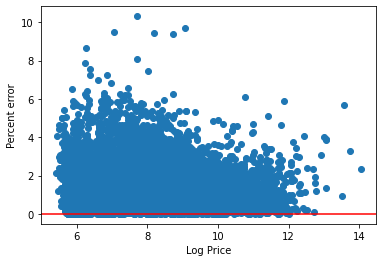

In [218]:
#gbr - 4Cs/log price
X = pd.get_dummies(df[['carat','cut','clarity','color']])
y = df.log_price
gbr(X,y,log=True,percent_error=True)


(3150.827361772167,
 3392.6737120932785,
 0.9954489899033643,
 0.9954085328089676,
 'Mean Absolute Percentage Error: 0.07092997204934726')

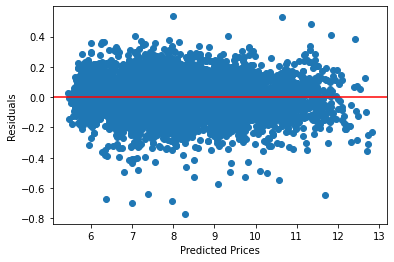

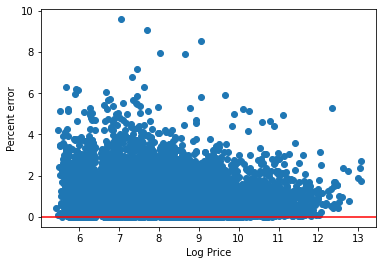

In [219]:
#gbr 4Cs log price - filtered <= 500K and <= 9.5 carats 
X = pd.get_dummies(df_filtered.drop(['original_price','log_price'],axis=1))
y = df_filtered.log_price
gbr(X,y,log=True,percent_error = True)

Try hypertuning Random Forest to compare to the gradient boosting regressor

In [224]:
#creating a random grid
n_estimators = [int(x) for x in np.linspace(start=200,stop=500, num =4)]
max_features = ['auto','sqrt']
min_samples_split = [2,5,10,15]
min_samples_leaf = [1,2,4,5,6]

random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [225]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 5, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [200, 300, 400, 500]},
                   random_state=42, verbose=2)

In [226]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

In [230]:
def rf(X,y,log = False, gini = False, percent_error = False ):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 23)
    
    if log == False:
        rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 15, min_samples_leaf = 1, max_features = 'auto', n_jobs = -1).fit(X_train,y_train)
        y_predicted = rf.predict(X_test)
        train_rmse = (f'Train RMSE: {(-cross_val_score(rf,X_train,y_train,scoring="neg_root_mean_squared_error")).mean()}')
        test_rmse = (f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted))}')
        train_r2 = (f'Train R2: {cross_val_score(rf,X_train,y_train,scoring="r2").mean()}')
        test_r2 = (f'Test R2: {r2_score(y_test,y_predicted)}')
        mape = (f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted)}')
        residuals = y_predicted - y_test
    else:
        fold_rmse = []
        fold_r2 = []
        # need to manually do KFolds to get rid of log during cross val
        # use default folds - which is 5 same as default for cross val score
        # reminder - KFold object returns indices not the data 
        kf = KFold(shuffle=True, random_state = 23)
        for train, test in kf.split(X_train):
            rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 15, min_samples_leaf = 1, max_features = 'auto', n_jobs = -1).fit(X_train.values[train],y_train.values[train])
            predicted_log = rf.predict(X_train.values[test])
            predicted_non_log = np.exp(predicted_log)
            true_non_log = np.exp(y_train.values[test])
            #want to take the log out for rmse to easier interpretability 
            fold_rmse.append(np.sqrt(np.mean((predicted_non_log-true_non_log)**2)))
            fold_r2.append(r2_score(y_train.values[test],predicted_log))
        train_rmse = np.mean(fold_rmse)
        train_r2 = np.mean(fold_r2)
        
        
        rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 15, min_samples_leaf = 1, max_features = 'auto', n_jobs = -1).fit(X_train,y_train)
        y_predicted = rf.predict(X_test)
        y_predicted_non_log = np.exp(y_predicted)
        
        test_rmse = np.sqrt(np.mean((y_predicted_non_log-np.exp(y_test))**2))
        test_r2 = r2_score(y_test,y_predicted)
        
        mape = (f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(np.exp(y_test),y_predicted_non_log)}')
        
        # want the residuals of when it was log - not after conversion 
        #residuals = y_predicted - np.exp(y_test)
        residuals = y_predicted - y_test


    fig,ax = plt.subplots()
    ax.scatter(y_predicted,residuals)
    plt.axhline(y=0, color = 'r')
    ax.set_xlabel('Predicted Prices')
    ax.set_ylabel('Residuals')
    
    
    # Plot the gini importance
    
    if gini == True:
        fig, ax = plt.subplots()
        feat_scores = pd.Series(rf.feature_importances_,
                                   index=X_train.columns)
        feat_scores = feat_scores.sort_values()
        ax = feat_scores.plot(kind='barh', 
                              figsize=(10,20),
                              color='b')
        ax.set_title('Average Gini Importance')
        ax.set_xlabel('Average contribution to information gain')
        
    if percent_error == True:
        percent_error = np.abs(y_predicted-y_test)/y_test*100
        fig,ax = plt.subplots()
        ax.scatter(y_test,percent_error)
        plt.axhline(y=0, color = 'r')
        ax.set_ylabel('Percent error')
        if log == False:
            ax.set_xlabel('Original Price')
        else: 
            ax.set_xlabel('Log Price')
        
    
    return train_rmse, test_rmse, train_r2, test_r2, mape

(4243.8783656677915,
 4857.4684900287575,
 0.9938939835696099,
 0.9940387797320268,
 'Mean Absolute Percentage Error: 0.07958577159223205')

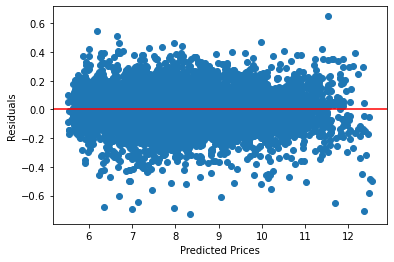

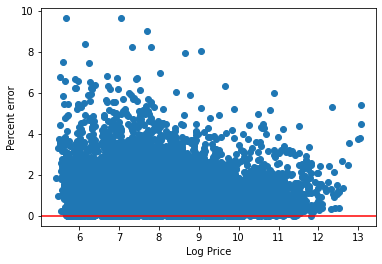

In [231]:
#random forest 4Cs log price - filtered <= 500K and <= 9.5 carats 
X = pd.get_dummies(df_filtered.drop(['original_price','log_price'],axis=1))
y = df_filtered.log_price
rf(X,y,log=True,percent_error = True)

Hyptertuned RF predicting with 4Cs is no longer underfitting. However, still using a random grid search for Gradient Boosting Regressor overall did better. Might be able to improve model if I took the time to do an better/ more exhaustive grid search.